In [13]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [14]:
def clean_data(df):
    df = df[(df['Extruder Pressure'] >= 0) & (df['Extruder Pressure'] < 50000)]
    
    return df

In [15]:
def get_machine_pauses(df, time_threshold=30, index=True):
    if index:
        time_diff = -1*(df.index.diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold].index
    else:
        time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold]['Date and Time']
    
    return machine_pauses

def calculate_time_difference(df, time_threshold=30):
    time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
    #time_diff = (df['Date and Time'].shift(-1) - df['Date and Time']).dt.total_seconds()/60

    return time_diff

In [16]:
import utils

In [17]:
def clean_extruder_data(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data

In [18]:
import pandas as pd
import re

columns_oi = ['Extruder Pressure']

ex4_data = clean_extruder_data( pd.read_csv("data/ex4-data.csv") )

/tmp/ipykernel_45424/1435864646.py:6: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  ex4_data = clean_extruder_data( pd.read_csv("data/ex4-data.csv") )


In [24]:
ex4_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,hours_to_next_pause
Date and Time,,,,,,,,,,,
2022-11-08 08:45:00,4174.38,63.1,-0.94,11.28,34.120,5.21,0.95,75.36,2022-11-08 08:45:00,NaN,1642.183333
2022-11-08 08:46:00,4521.09,63.1,-0.94,11.28,34.370,5.21,0.95,75.36,2022-11-08 08:46:00,NaN,1642.166667
2022-11-08 08:49:00,4521.09,63.1,-0.94,11.28,34.620,5.21,1.01,75.36,2022-11-08 08:49:00,NaN,1642.116667
2022-11-08 08:50:00,4521.09,63.1,-0.94,11.28,34.035,5.21,0.90,75.36,2022-11-08 08:50:00,NaN,1642.100000
2022-11-08 08:53:00,4337.32,63.1,-0.94,11.28,33.450,1.74,0.90,75.36,2022-11-08 08:53:00,NaN,1642.050000


In [26]:
ex4_data.tail()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,hours_to_next_pause
Date and Time,,,,,,,,,,,
2023-04-25 18:07:00,2265.96,25.0,-0.94,11.30,36.88,0.0,1.05,70.0,2023-04-25 18:07:00,128.483333,0.066667
2023-04-25 18:08:00,2514.48,25.0,-0.94,11.30,36.88,0.0,0.93,70.0,2023-04-25 18:08:00,128.500000,0.050000
2023-04-25 18:10:00,2514.48,25.0,-0.94,11.30,7.14,0.0,0.93,70.0,2023-04-25 18:10:00,128.533333,0.016667
2023-04-25 18:11:00,394.56,25.0,-0.94,11.30,7.14,0.0,0.93,70.0,2023-04-25 18:11:00,0.000000,0.000000
2023-04-25 18:50:00,910.56,25.0,-0.94,397.83,-0.83,0.0,0.04,70.0,2023-04-25 18:50:00,0.650000,NaN


In [25]:
len(ex4_data)

98664

In [19]:

ex4_data = ex4_data.groupby('Date and Time').mean()

# resampling every 5 minutes instead of 1 minute

ex4_resampled = ex4_data.resample('5T').mean()

In [20]:

ex4_data['Date and Time'] = ex4_data.index
ex4_pauses = get_machine_pauses(ex4_data, time_threshold=15, index=False)

pauses = ex4_pauses

In [21]:
def hours_since_last_pause(time, pauses):
    return (time - pauses[pauses <= time].max()).total_seconds()/3600

def hours_to_next_pause(time, pauses):
    return (pauses[pauses >= time].min() - time).total_seconds()/3600

In [23]:
%%time
#from tqdm import tqdm
from tqdm import tqdm
tqdm.pandas()

ex4_data['hours_since_last_pause'] = ex4_data.index.to_series().progress_apply(
    lambda x : hours_since_last_pause(x, pauses)
)
ex4_data['hours_to_next_pause'] = ex4_data.index.to_series().progress_apply(
    lambda x : hours_to_next_pause(x, pauses)
)

100%|███████████████████████████████████████████████████████████████████████| 98664/98664 [00:20<00:00, 4790.98it/s]

CPU times: user 38.7 s, sys: 83.2 ms, total: 38.8 s
Wall time: 38.8 s


In [103]:

for time_window in ['15T', '30T', '1H', '2H', '3H', '6H', '12H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex4_data[col_label] = ex4_data['Extruder Pressure'].rolling(time_window).mean()

In [104]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}

for time_window in ['15T', '1H', '3H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex4_data[col_label] = \
            ex4_data[lagvar].rolling(time_window).mean()

In [105]:
min_datetime = pauses.min() - pd.Timedelta(days=7)
max_datetime = pauses.max()

time_mask = (ex4_data.index >= min_datetime) \
            & (ex4_data.index <= max_datetime)
ex4_data = ex4_data[time_mask]

redundancy_mask = (ex4_data['hours_since_last_pause'] >= 3) \
                  | (ex4_data['hours_to_next_pause'] >= 3)
ex4_data = ex4_data[redundancy_mask]

In [106]:
target_features = ['hours_to_next_pause']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
]

In [107]:
ex4_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,...,pressure-12hour_avg,die_temp-15min_avg,thrust-15min_avg,screw_speed_output-15min_avg,die_temp-1hour_avg,thrust-1hour_avg,screw_speed_output-1hour_avg,die_temp-3hour_avg,thrust-3hour_avg,screw_speed_output-3hour_avg
Date and Time,,,,,,,,,,,,,,,,,,,,,
2023-01-08 18:56:00,4490.480000,25.0,-0.94,10.88,48.900,5.25,0.9,80.0,2023-01-08 18:56:00,NaN,...,4276.075865,10.88,49.580714,25.0,10.88,49.701604,25.0,10.88,49.625584,25.0
2023-01-08 18:58:00,4304.433333,25.0,-0.94,10.88,49.815,4.37,0.9,80.0,2023-01-08 18:58:00,NaN,...,4276.022199,10.88,49.543214,25.0,10.88,49.726985,25.0,10.88,49.629611,25.0
2023-01-08 18:59:00,4215.190000,25.0,-0.94,10.88,49.700,0.00,0.9,80.0,2023-01-08 18:59:00,NaN,...,4275.750657,10.88,49.624214,25.0,10.88,49.752120,25.0,10.88,49.632620,25.0
2023-01-08 19:01:00,3972.940000,25.0,-0.94,10.88,50.610,0.00,0.9,80.0,2023-01-08 19:01:00,NaN,...,4274.793409,10.88,49.712460,25.0,10.88,49.801850,25.0,10.88,49.641193,25.0
2023-01-08 19:03:00,3972.940000,25.0,-0.94,10.88,50.610,5.97,0.9,80.0,2023-01-08 19:03:00,NaN,...,4274.391750,10.88,49.802214,25.0,10.88,49.803742,25.0,10.88,49.655901,25.0


In [108]:
ex4_data.index.min(),  ex4_data.index.max()

(Timestamp('2023-01-08 18:56:00'), Timestamp('2023-04-25 18:10:00'))

In [109]:
ex4_data.head().T

Date and Time,2023-01-08 18:56:00,2023-01-08 18:58:00,2023-01-08 18:59:00,2023-01-08 19:01:00,2023-01-08 19:03:00
Extruder Pressure,4490.48,4304.433333,4215.19,3972.94,3972.94
Screw Speed Output,25.0,25.0,25.0,25.0,25.0
Screw Speed,-0.94,-0.94,-0.94,-0.94,-0.94
Extruder Die Temp,10.88,10.88,10.88,10.88,10.88
Extruder Thrust,48.9,49.815,49.7,50.61,50.61
Feed Screw Current (Amps),5.25,4.37,0.0,0.0,5.97
Discharge Conveyor Current (Amps),0.9,0.9,0.9,0.9,0.9
Discharge Conveyor Speed (%),80.0,80.0,80.0,80.0,80.0
Date and Time,2023-01-08 18:56:00,2023-01-08 18:58:00,2023-01-08 18:59:00,2023-01-08 19:01:00,2023-01-08 19:03:00
hours_since_last_pause,NaN,NaN,NaN,NaN,NaN


In [110]:
model_input = ex4_data[ex4_data['hours_to_next_pause'] <= 6][input_features]
model_output = ex4_data[ex4_data['hours_to_next_pause'] <= 6][target_features]

In [111]:
train_split_cutoff = pd.to_datetime('04/01/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-2hour_avg
pressure-3hour_avg
die_temp-15min_avg
thrust-15min_avg
screw_speed_output-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
screw_speed_output-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
screw_speed_output-3hour_avg
balanced true samples: 2, balanced false samples: 0

Current Time: 08:40:18
results for target: hours_to_next_pause, model: Linear Regression


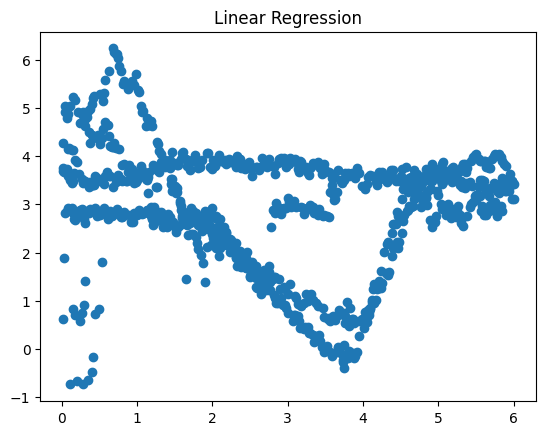

average prediction:  2.9009300256197545, std: 1.2466635774479253
min prediction:  -0.7361735411354444, max prediction: 6.2316451541257205
{'MSE': 5.276261419086318, 'MAE': 1.9546348665067461, 'R2': -0.7194398036256249}
--------------------------------------
Run time: 0.00 minutes
Current Time: 08:40:18
--------------------------------------

Current Time: 08:40:18
results for target: hours_to_next_pause, model: Random Forest Regressor


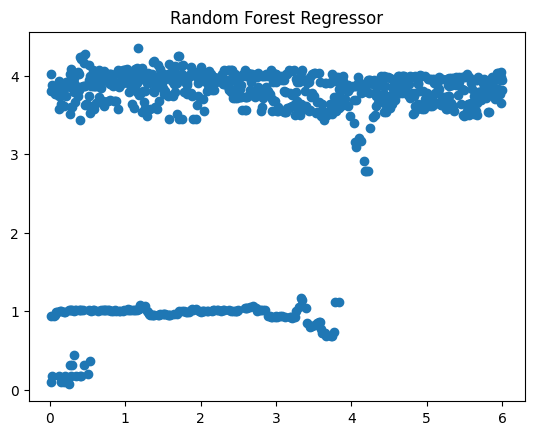

average prediction:  3.2772928383952005, std: 1.1632323240350548
min prediction:  0.06483333333333328, max prediction: 4.346833333333332
{'MSE': 3.5375945961754773, 'MAE': 1.5670183727034122, 'R2': -0.15283919324989825}
--------------------------------------
Run time: 0.02 minutes
Current Time: 08:40:19
--------------------------------------

Current Time: 08:40:19
results for target: hours_to_next_pause, model: Support Vector Regressor


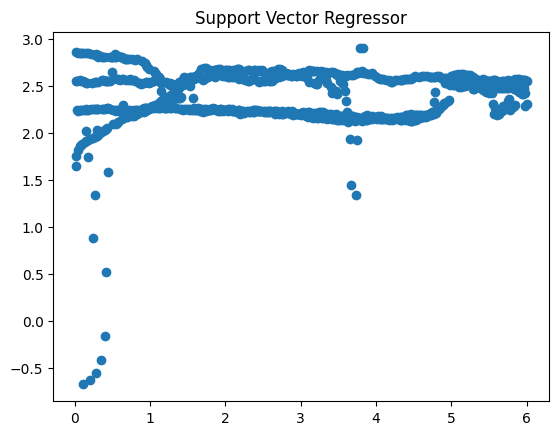

average prediction:  2.385321556461677, std: 0.32156429197047653
min prediction:  -0.6749485820773584, max prediction: 2.899701888637333
{'MSE': 3.2109240256297733, 'MAE': 1.5255179595843418, 'R2': -0.04638306133089953}
--------------------------------------
Run time: 0.02 minutes
Current Time: 08:40:19
--------------------------------------

Current Time: 08:40:19
results for target: hours_to_next_pause, model: K-Nearest Neighbors Regressor


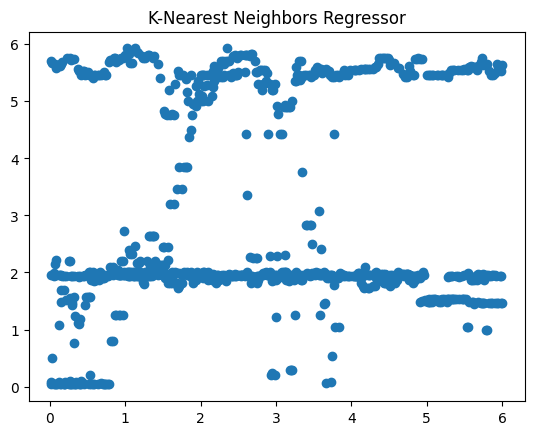

average prediction:  2.930847394075741, std: 1.8124175083794671
min prediction:  0.03666666666666667, max prediction: 5.926666666666668
{'MSE': 5.655327721534808, 'MAE': 1.9005736782902138, 'R2': -0.842970773165036}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:40:19
--------------------------------------

Current Time: 08:40:19
results for target: hours_to_next_pause, model: Gradient Boosting Regressor


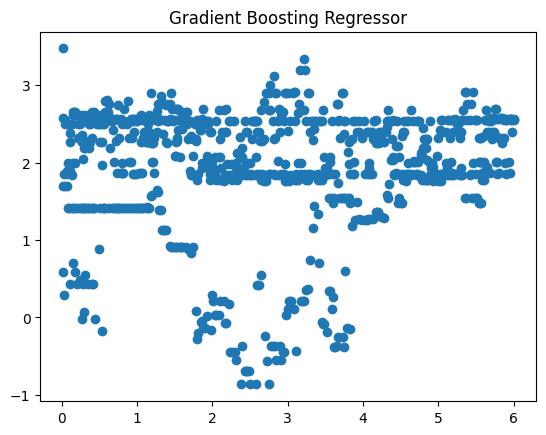

average prediction:  1.9229392915117178, std: 0.8041890982113498
min prediction:  -0.8673186836879082, max prediction: 3.4748495568154443
{'MSE': 4.304175276642314, 'MAE': 1.7557346124662918, 'R2': -0.4026542099806931}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:40:20
--------------------------------------

Current Time: 08:40:20
results for target: hours_to_next_pause, model: MLP Regressor


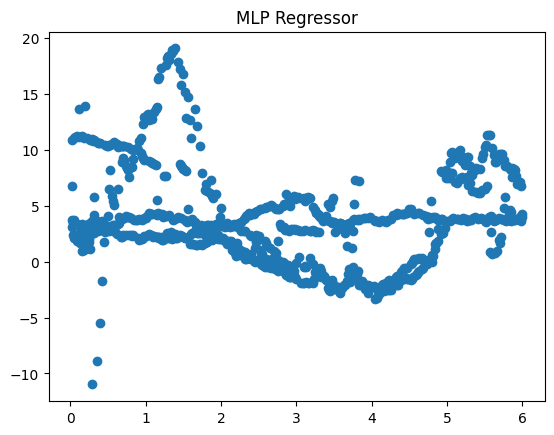

average prediction:  3.704652834873704, std: 4.0818511154074795
min prediction:  -10.982137660405705, max prediction: 19.05572992860467
{'MSE': 22.52700768248165, 'MAE': 3.4341411783500067, 'R2': -6.341151354958198}
--------------------------------------
Run time: 0.05 minutes
Current Time: 08:40:21
--------------------------------------


In [119]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
import matplotlib.pyplot as plt

import time
import pickle

print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_next_pause'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_true = np.sum((Y_train == 1))
n_false = np.sum((Y_train == 0))

print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')
    
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    
    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

In [113]:
with open('regression_models_no_screw_speed_no_5T_ex4.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)

In [114]:
target_features = ['hours_to_next_pause']
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'screw_speed_output-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'screw_speed_output-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'screw_speed_output-3hour_avg',
]

In [115]:
model_input = ex4_data[ex4_data['hours_to_next_pause'] <= 6][input_features]
model_output = ex4_data[ex4_data['hours_to_next_pause'] <= 6][target_features]

In [116]:
train_split_cutoff = pd.to_datetime('04/01/2023')
model_input_train = model_input[model_input.index < train_split_cutoff]
model_input_test = model_input[model_input.index >= train_split_cutoff]

model_output_train = model_output[model_output.index < train_split_cutoff]
model_output_test = model_output[model_output.index >= train_split_cutoff]

input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-2hour_avg
pressure-3hour_avg
die_temp-15min_avg
thrust-15min_avg
screw_speed_output-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
screw_speed_output-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
screw_speed_output-3hour_avg
balanced true samples: 2, balanced false samples: 0

Current Time: 08:40:53
results for target: hours_to_next_pause, model: Linear Regression


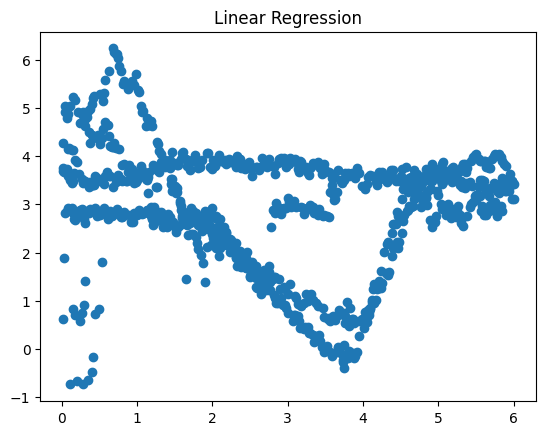

average prediction:  2.9009300256197545, std: 1.2466635774479253
min prediction:  -0.7361735411354444, max prediction: 6.2316451541257205
{'MSE': 5.276261419086318, 'MAE': 1.9546348665067461, 'R2': -0.7194398036256249}
--------------------------------------
Run time: 0.00 minutes
Current Time: 08:40:53
--------------------------------------

Current Time: 08:40:53
results for target: hours_to_next_pause, model: Random Forest Regressor


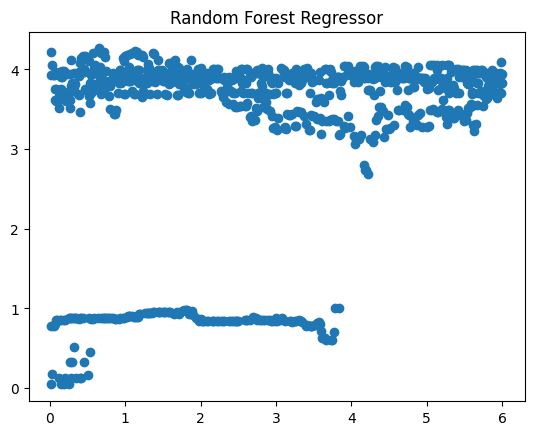

average prediction:  3.2248123359580045, std: 1.1921994243574037
min prediction:  0.045999999999999985, max prediction: 4.262333333333333
{'MSE': 3.5865830472128475, 'MAE': 1.574102174728159, 'R2': -0.16880365860540847}
--------------------------------------
Run time: 0.02 minutes
Current Time: 08:40:54
--------------------------------------

Current Time: 08:40:54
results for target: hours_to_next_pause, model: Support Vector Regressor


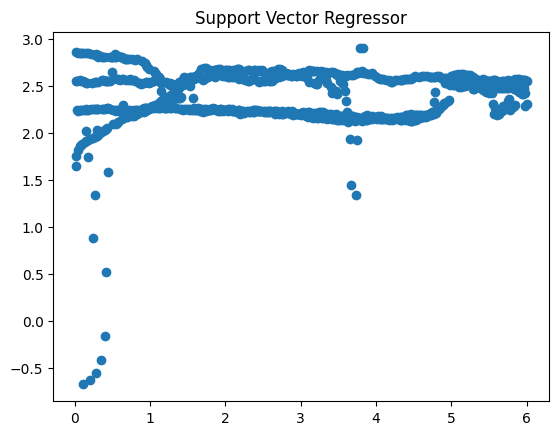

average prediction:  2.385321556461677, std: 0.32156429197047653
min prediction:  -0.6749485820773584, max prediction: 2.899701888637333
{'MSE': 3.2109240256297733, 'MAE': 1.5255179595843418, 'R2': -0.04638306133089953}
--------------------------------------
Run time: 0.02 minutes
Current Time: 08:40:54
--------------------------------------

Current Time: 08:40:54
results for target: hours_to_next_pause, model: K-Nearest Neighbors Regressor


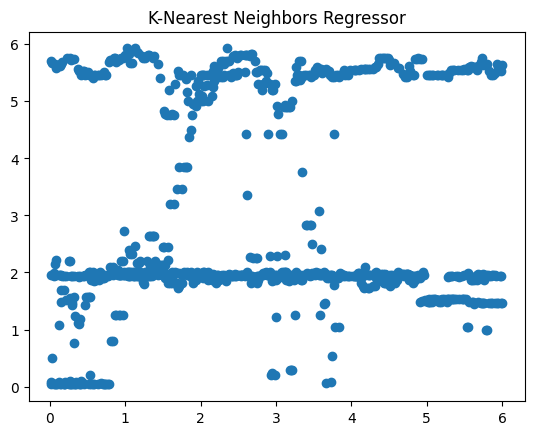

average prediction:  2.930847394075741, std: 1.8124175083794671
min prediction:  0.03666666666666667, max prediction: 5.926666666666668
{'MSE': 5.655327721534808, 'MAE': 1.9005736782902138, 'R2': -0.842970773165036}
--------------------------------------
Run time: 0.02 minutes
Current Time: 08:40:55
--------------------------------------

Current Time: 08:40:55
results for target: hours_to_next_pause, model: Gradient Boosting Regressor


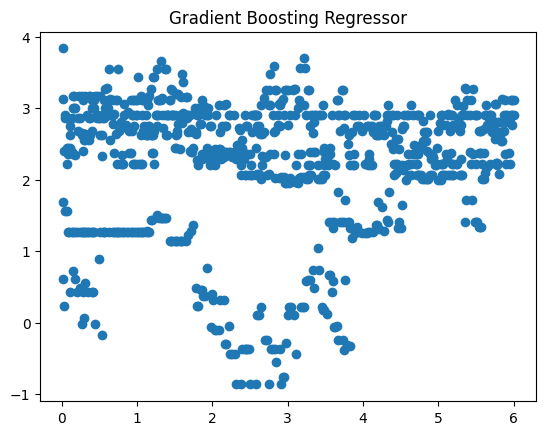

average prediction:  2.210501985287149, std: 0.9406224344045118
min prediction:  -0.8673186836879072, max prediction: 3.8359713630539023
{'MSE': 4.105740776620274, 'MAE': 1.727802654773081, 'R2': -0.33798793387158943}
--------------------------------------
Run time: 0.03 minutes
Current Time: 08:40:55
--------------------------------------

Current Time: 08:40:55
results for target: hours_to_next_pause, model: MLP Regressor


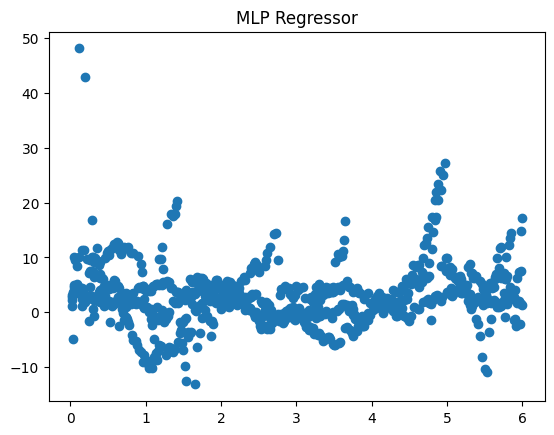

average prediction:  2.9981312772535977, std: 5.377040155845706
min prediction:  -13.153183485202419, max prediction: 48.06620856513932
{'MSE': 30.96461239148031, 'MAE': 3.926994415235, 'R2': -9.09081673951066}
--------------------------------------
Run time: 0.05 minutes
Current Time: 08:40:56
--------------------------------------


In [120]:
print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
start_time = time.time()
results = dict()

targ = 'hours_to_next_pause'

results[targ] = dict()
output_models[targ] = dict()
#y = model_output[targ].values

X_train = model_input_train[model_output_train[targ].notnull()].values
X_test = model_input_test[model_output_test[targ].notnull()].values

Y_train = model_output_train[model_output_train[targ].notnull()][targ].values
Y_test = model_output_test[model_output_test[targ].notnull()][targ].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_true = np.sum((Y_train == 1))
n_false = np.sum((Y_train == 0))

print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
for name, model in models.items():
    print()
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print(f'results for target: {targ}, model: {name}')
    model.fit(X_train, Y_train)
    output_models[targ][name] = model

    predictions = model.predict(X_test)
    
    plt.scatter(Y_test, predictions)
    plt.title(f'{name}')
    plt.show()
    
    print(f'average prediction:  {np.mean(predictions)}, std: {np.std(predictions)}')
    print(f'min prediction:  {np.min(predictions)}, max prediction: {np.max(predictions)}')

    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)

    results[targ][name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(results[targ][name])
    print('--------------------------------------')

    duration = time.time() - start_time
    print(f"Run time: {duration / 60:.2f} minutes")
    print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
    print('--------------------------------------')

In [118]:
with open('regression_models_with_screw_speed_no_5T_ex4.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)